## 3장 : 평가(Evaluation)

### 성능 평가지표

* 정확도(Accuracy) : 예측 데이터가 동일한 데이터 건수 / 전체 예측 데이터 건수 -> (TN + TP) / (TN + TP + FN + FP)
* 정밀도(Precision) : 예측대상(Positive)를 정확히 예측한 수 / Positive로 예측한 수 -> TP / (TP + FP)
* 재현율(Recall) : 예측대상(Positive)를 정확히 예측한 수 / 전체 Positive 데이터의 수 -> TP / (Tp + FN)
* 특이성(Specificity),True Negative Rate(TNR) : Negative를 를 정확히 예측한 수 / 전체 Negative 데이터 수 -> TN / (TN + FP)
* F1 score : 2*((Precision*Recall)/(Precision + Recall))

* 업무에 따라 다르게 쓰임 -> 정밀도 : 암, 사기 예측, 재현율 : 스팸메일

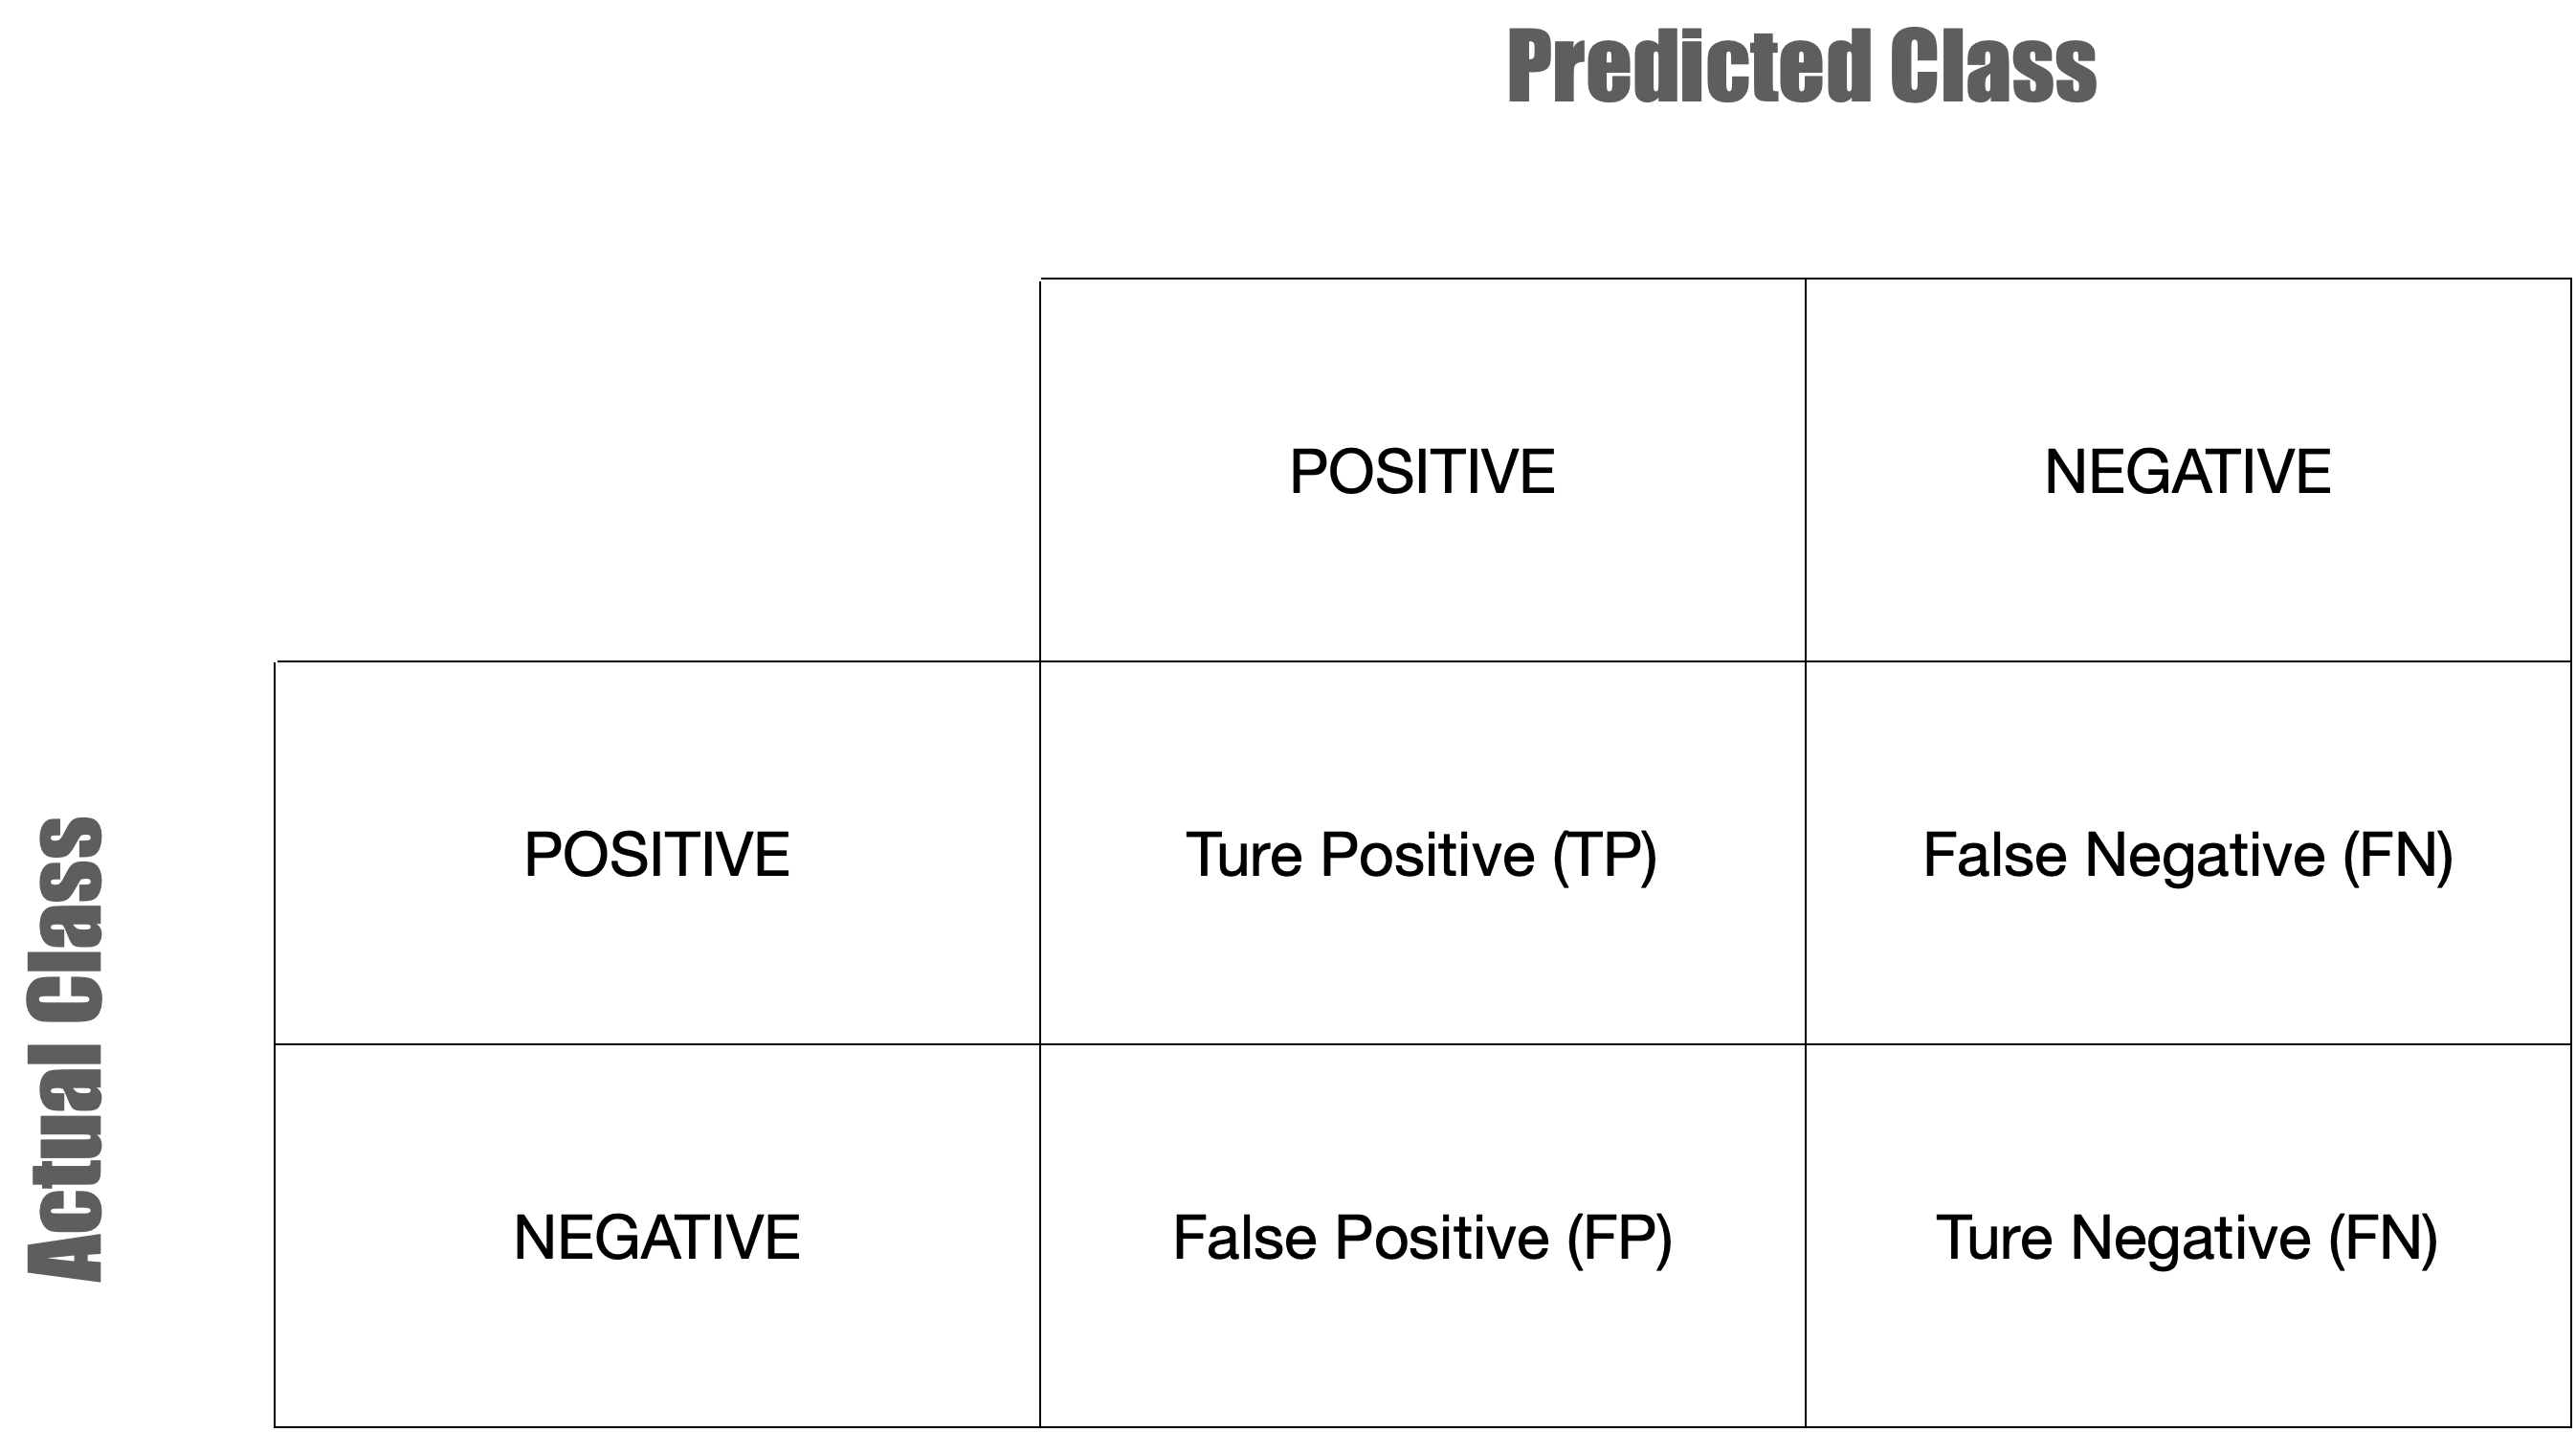

In [27]:
Image('confusion matrix.png', width = 600)

### 라이브러리 Import

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from IPython.display import Image

### 데이터 가져오기

In [3]:
data = pd.read_csv('data.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0또는 1)

In [5]:
print(data['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


### 평가지표 함수 만들기

In [6]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},\
    F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
def precision_recall_curve_plot(y_test = None, pred_proba_cl = None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X 축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 5))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # X 축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

### Logisticc Regression으로 학습 및 예측 수행
* stratify를 y로 설정하면 target의 class 비율을 유지한 채 데이터 셋을 split하게 됨

In [13]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도 : 0.7111, 재현율 : 0.5926,    F1 : 0.6465, AUC : 0.8083


### Precision recall 곡선 그림

* precision과 recall은 상호보완적인 속성이 있어 한쪽을 높이면 한쪽이 떨어지는 경향을 보인다.

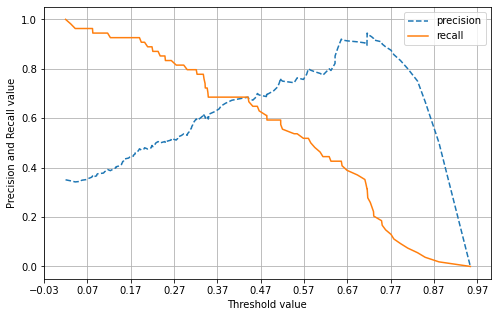

In [22]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

### 각 피처들의 값 4분위 분포 확인

In [29]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


* 혈압, 포도당 및 인슐린에서 min값이 0인 것은 존재할 수 없음 
* 이를 확인하여 결손치를 채우는 과정이 필요

### Glucose 피처의 분포도

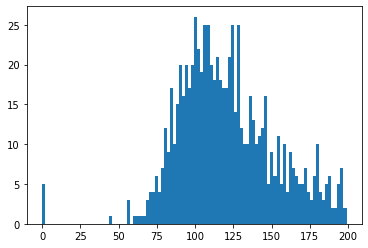

In [31]:
plt.hist(data['Glucose'], bins = 100)
plt.show()

* 히스토그램에서 확인한 바로는 다수의 0값이 존재함
* 다른 feature들에서 이런 값이 얼마나 존재하는지 확인 필요

### 0값이 있는 피처들에서 0값의 데이터 건수와 퍼센트 계산

In [33]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0인 데이터 건수 추출 후 퍼센트 계산
for feature in zero_features :
    zero_count = data[data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, zero_count/total_count * 100))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


### 0값을 평균값으로 대체

In [35]:
data[zero_features] = data[zero_features].replace(0, data[zero_features].mean())

### StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용하고 0값을 평균값으로 대체한 데이터 세트로 학습/예측

In [36]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 지목
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,    F1 : 0.6804, AUC : 0.8433


### 분류결정 임계값을 변경하면서 성능 측정

- thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행

In [37]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 : ', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [40]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.3
오차 행렬
[[65 35]
 [11 43]]
정확도 : 0.7013, 정밀도 : 0.5513, 재현율 : 0.7963,    F1 : 0.6515, AUC : 0.8433
임계값 :  0.33
오차 행렬
[[71 29]
 [11 43]]
정확도 : 0.7403, 정밀도 : 0.5972, 재현율 : 0.7963,    F1 : 0.6825, AUC : 0.8433
임계값 :  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222,    F1 : 0.6667, AUC : 0.8433
임계값 :  0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037,    F1 : 0.6667, AUC : 0.8433
임계값 :  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667,    F1 : 0.6792, AUC : 0.8433
임계값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667,    F1 : 0.6857, AUC : 0.8433
임계값 :  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481,    F1 : 0.6931, AUC : 0.8433
임계값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,    F1 : 0.6804, AUC : 0.8433


In [41]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481,    F1 : 0.6931, AUC : 0.8433
